이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [4]:
from keras.datasets import fashion_mnist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [5]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [6]:
# 데이터 크기 확인
print("Training data shape:", train_images.shape, train_labels.shape)
print("Test data shape:", test_images.shape, test_labels.shape)

# 결측치 여부 확인
print("Training images missing values:", np.isnan(train_images).sum())
print("Test images missing values:", np.isnan(test_images).sum())
print("Training labels missing values:", np.isnan(train_labels).sum())
print("Test labels missing values:", np.isnan(test_labels).sum())

# 데이터의 간단한 통계 요약 (평균, 표준편차 등)
print("Training images stats - Mean:", np.mean(train_images), ", Std Dev:", np.std(train_images))
print("Test images stats - Mean:", np.mean(test_images), ", Std Dev:", np.std(test_images))

Training data shape: (60000, 28, 28) (60000,)
Test data shape: (10000, 28, 28) (10000,)
Training images missing values: 0
Test images missing values: 0
Training labels missing values: 0
Test labels missing values: 0
Training images stats - Mean: 72.94035223214286 , Std Dev: 90.02118235130519
Test images stats - Mean: 73.14656658163265 , Std Dev: 89.87325907809718


### Data중 첫 번째 이미지를 보여주세요.

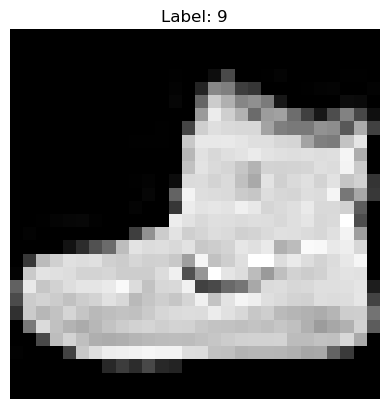

In [7]:
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.axis('off')  # 축 숨기기
plt.show()

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [8]:
train_images_flat = train_images.reshape(-1, 28 * 28) / 255.0
test_images_flat = test_images.reshape(-1, 28 * 28) / 255.0

### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

In [9]:
n_samples = 1000
images_sample = train_images_flat[:n_samples]
labels_sample = train_labels[:n_samples]

# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

PCA (Principal Component Analysis)
데이터의 분산을 최대한 보존하는 축을 찾아 데이터를 투영합니다. 이 축을 주성분(Principal Component)이라 부르며, 데이터의 변동성이 큰 축이 상위 주성분이 됩니다.

t-SNE (t-Distributed Stochastic Neighbor Embedding)
고차원에서 유사한 데이터 포인트가 저차원에서도 유사하게 위치하도록, 데이터 포인트 간의 확률적 거리 관계를 보존하는 방식으로 차원을 축소합니다.

## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [10]:
pca = PCA(n_components=50)
train_images_pca = pca.fit_transform(train_images_flat)

### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [11]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each component:", explained_variance_ratio)


Explained variance ratio for each component: [0.29039228 0.1775531  0.06019222 0.04957428 0.03847655 0.03460769
 0.02341691 0.01905414 0.01349843 0.01314267 0.00992875 0.00913255
 0.00765793 0.00659706 0.00607851 0.00589821 0.00551934 0.005245
 0.00458079 0.00455515 0.00433684 0.00407097 0.00384758 0.00372551
 0.00361107 0.00350656 0.00333241 0.00319359 0.00308063 0.00293273
 0.00275601 0.00265061 0.00263702 0.00255831 0.00246209 0.00235893
 0.00230283 0.00225514 0.00218462 0.00209293 0.00200178 0.00195707
 0.00194651 0.00182444 0.00175261 0.00171773 0.00168173 0.00162682
 0.0016061  0.00154081]


In [12]:
train_images_reconstructed = pca.inverse_transform(train_images_pca)

### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [13]:
# 재구성 오차 (MSE) 계산
reconstruction_error = mean_squared_error(train_images_flat, train_images_reconstructed)
print("Reconstruction Error (MSE):", reconstruction_error)

Reconstruction Error (MSE): 0.011950589421595723


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [14]:
pca = PCA(n_components=30)
train_images_pca = pca.fit_transform(train_images_flat)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each component:", explained_variance_ratio)
print("Cumulative explained variance ratio:", explained_variance_ratio.cumsum()[-1])

# PCA를 이용해 원본 차원으로 복원
train_images_reconstructed = pca.inverse_transform(train_images_pca)

# 재구성 오차 (MSE) 계산
reconstruction_error = mean_squared_error(train_images_flat, train_images_reconstructed)
print("Reconstruction Error (MSE):", reconstruction_error)

Explained variance ratio for each component: [0.29039228 0.1775531  0.06019222 0.04957428 0.03847655 0.03460769
 0.02341691 0.01905414 0.01349843 0.01314267 0.00992875 0.00913255
 0.00765793 0.00659706 0.00607851 0.00589821 0.00551934 0.005245
 0.00458078 0.00455513 0.00433683 0.00407092 0.00384738 0.00372506
 0.00361036 0.00350612 0.00333222 0.00319055 0.00307832 0.0029306 ]
Cumulative explained variance ratio: 0.820729897865777
Reconstruction Error (MSE): 0.015598387851648021


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

50차원일 때의 재구성 오차(MSE)는 0.0119입니다.
30차원일 때 재구성 오차(MSE)는 0.0155로, 50차원보다 큽니다.
재구성 오차가 높다는 것은, 30차원으로 줄였을 때 원본 데이터를 복원하는 데 더 많은 손실이 발생한다는 의미입니다. 따라서, 50차원으로 축소한 경우가 30차원보다 원본 데이터와 더 유사한 복원이 가능합니다.

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [15]:
pca = PCA(n_components=2)
train_images_pca = pca.fit_transform(train_images_flat)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each component:", explained_variance_ratio)
print("Cumulative explained variance ratio:", explained_variance_ratio.cumsum()[-1])

# PCA를 이용해 원본 차원으로 복원
train_images_reconstructed = pca.inverse_transform(train_images_pca)

# 재구성 오차 (MSE) 계산
reconstruction_error = mean_squared_error(train_images_flat, train_images_reconstructed)
print("Reconstruction Error (MSE):", reconstruction_error)

Explained variance ratio for each component: [0.29039228 0.1775531 ]
Cumulative explained variance ratio: 0.46794537899528205
Reconstruction Error (MSE): 0.04629435827776491


### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

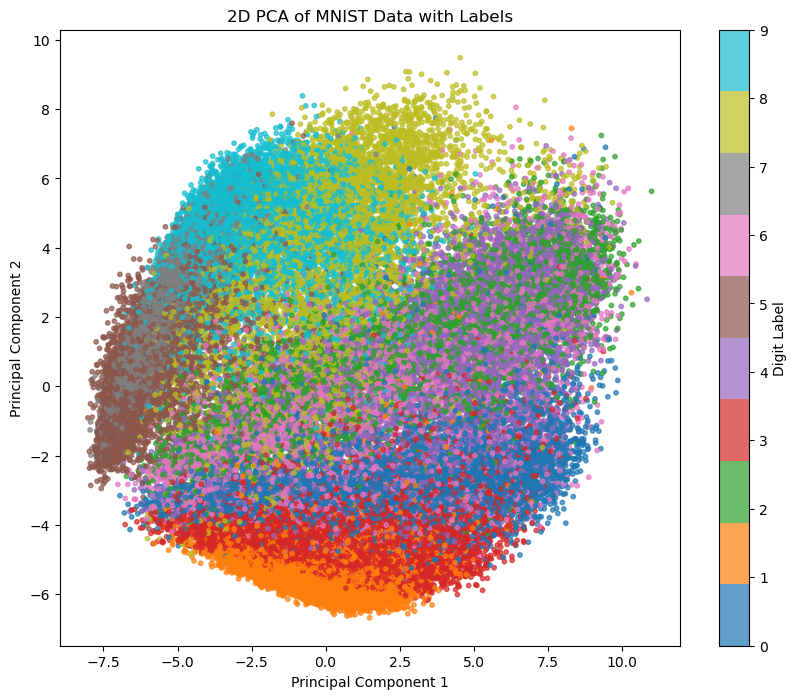

In [16]:
pca = PCA(n_components=2)
train_images_pca_2d = pca.fit_transform(train_images_flat)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_pca_2d[:, 0], train_images_pca_2d[:, 1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, label='Digit Label')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA of MNIST Data with Labels")
plt.show()

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

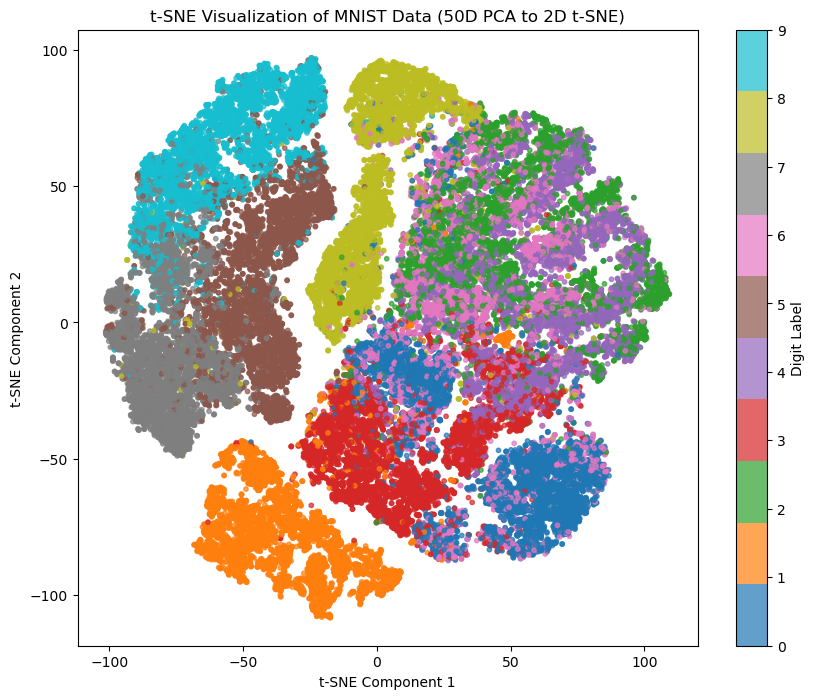

In [17]:
# PCA 수행 
pca = PCA(n_components=50)
train_images_pca = pca.fit_transform(train_images_flat)

# 50차원으로 축소된 데이터에서 t-SNE 수행
tsne = TSNE(n_components=2, random_state=42)
train_images_tsne_2d = tsne.fit_transform(train_images_pca)

# t-SNE 결과 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne_2d[:, 0], train_images_tsne_2d[:, 1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, label='Digit Label')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of MNIST Data (50D PCA to 2D t-SNE)")
plt.show()

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

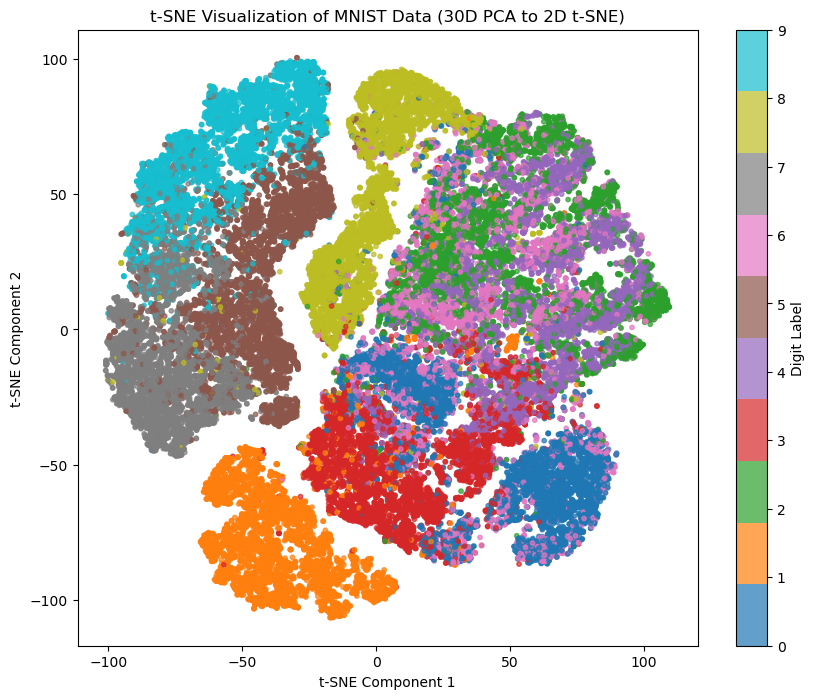

In [18]:
# PCA 수행
pca = PCA(n_components=30)
train_images_pca = pca.fit_transform(train_images_flat)

# 50차원으로 축소된 데이터에서 t-SNE 수행 (2차원으로 축소)
tsne = TSNE(n_components=2, random_state=42)
train_images_tsne_2d = tsne.fit_transform(train_images_pca)

# t-SNE 결과 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne_2d[:, 0], train_images_tsne_2d[:, 1], c=train_labels, cmap='tab10', s=10, alpha=0.7)

plt.colorbar(scatter, label='Digit Label')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of MNIST Data (30D PCA to 2D t-SNE)")
plt.show()

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

In [19]:
# PCA 수행 (50차원으로 축소)
pca = PCA(n_components=50)
train_images_pca = pca.fit_transform(train_images_flat)

# DBSCAN을 사용하여 군집화 수행
dbscan = DBSCAN(eps=5, min_samples=5)
clusters = dbscan.fit_predict(train_images_pca)

# 결과 확인
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# 실루엣 점수 계산 (노이즈 포인트 제외)
if n_clusters > 1:  # 클러스터가 1개 이상일 때만 실루엣 점수 계산
    silhouette_avg = silhouette_score(train_images_pca[clusters != -1], clusters[clusters != -1])
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("Not enough clusters to calculate silhouette score.")

Estimated number of clusters: 1
Estimated number of noise points: 196
Not enough clusters to calculate silhouette score.


### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

In [20]:
# K-Means를 사용하여 10개의 군집으로 클러스터링 수행
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(train_images_pca)

# 클러스터링 결과 확인
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")
print(f"Cluster labels: {clusters}")

# 실루엣 점수 계산
silhouette_avg = silhouette_score(train_images_pca, clusters)
print(f"Silhouette Score: {silhouette_avg}")

Cluster centers shape: (10, 50)
Cluster labels: [6 8 5 ... 0 7 7]
Silhouette Score: 0.17736178560840266


### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

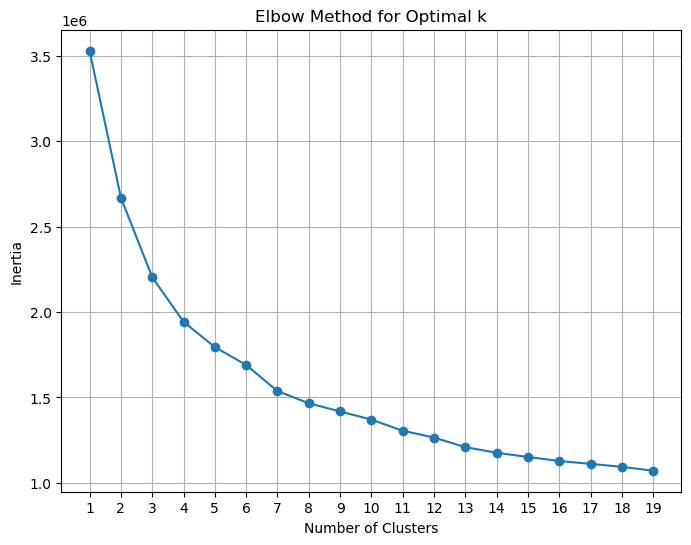

In [21]:
# 엘보우 메소드: 군집 수를 변화시키며 Inertia 계산
inertia = []
cluster_range = range(1, 20)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_images_pca)
    inertia.append(kmeans.inertia_)

# Inertia를 시각화하여 엘보우 포인트 확인
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

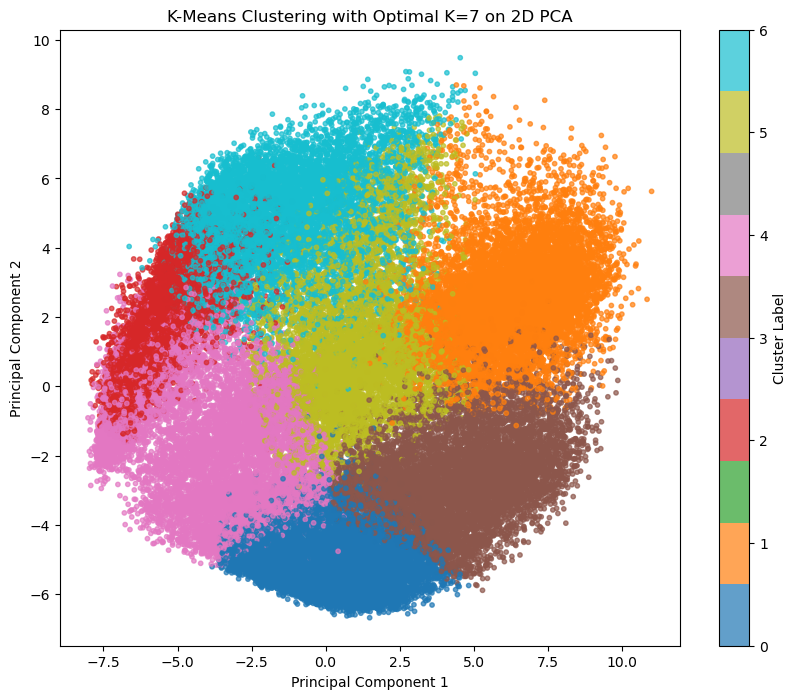

In [22]:
# PCA 수행 (50차원으로 축소)
pca = PCA(n_components=50)
train_images_pca = pca.fit_transform(train_images_flat)

# 최적의 군집 개수로 K-Means 클러스터링 수행 (K=7로 가정)
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(train_images_pca)

# 2차원 시각화를 위해 PCA로 2차원으로 추가 축소
pca_2d = PCA(n_components=2)
train_images_pca_2d = pca_2d.fit_transform(train_images_pca)

# 군집화 결과 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_pca_2d[:, 0], train_images_pca_2d[:, 1], c=clusters, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, label='Cluster Label')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"K-Means Clustering with Optimal K={optimal_k} on 2D PCA")
plt.show()

### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

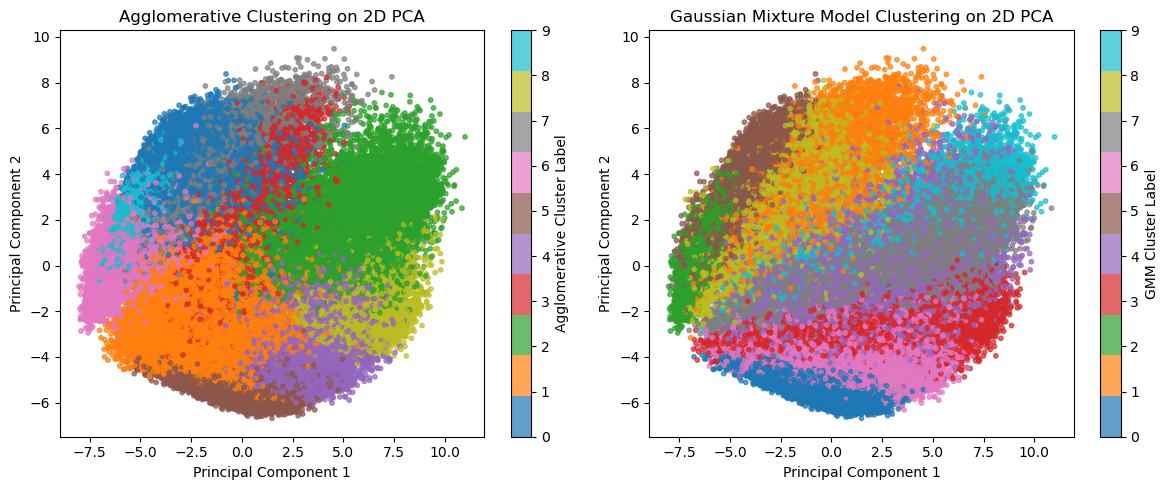

In [23]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# PCA 수행 (50차원으로 축소)
pca = PCA(n_components=50)
train_images_pca = pca.fit_transform(train_images_flat)

# Agglomerative Clustering 군집화 (K=10)
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_clusters = agg_clustering.fit_predict(train_images_pca)

# GMM 군집화 (K=10)
gmm = GaussianMixture(n_components=10, random_state=42)
gmm_clusters = gmm.fit_predict(train_images_pca)

# 2차원 시각화를 위해 다시 PCA로 2차원 축소
pca_2d = PCA(n_components=2)
train_images_pca_2d = pca_2d.fit_transform(train_images_pca)

# Agglomerative Clustering 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
scatter_agg = plt.scatter(train_images_pca_2d[:, 0], train_images_pca_2d[:, 1], c=agg_clusters, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter_agg, label='Agglomerative Cluster Label')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Agglomerative Clustering on 2D PCA")

# GMM 결과 시각화
plt.subplot(1, 2, 2)
scatter_gmm = plt.scatter(train_images_pca_2d[:, 0], train_images_pca_2d[:, 1], c=gmm_clusters, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter_gmm, label='GMM Cluster Label')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Gaussian Mixture Model Clustering on 2D PCA")

plt.tight_layout()
plt.show()

## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

In [24]:
# PCA 수행 (50차원으로 축소)
pca = PCA(n_components=50)
train_images_pca = pca.fit_transform(train_images_flat)

# K-Means (K=7)
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_clusters = kmeans.fit_predict(train_images_pca)
kmeans_silhouette = silhouette_score(train_images_pca, kmeans_clusters)

# Agglomerative Clustering (K=10)
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_clusters = agg_clustering.fit_predict(train_images_pca)
agg_silhouette = silhouette_score(train_images_pca, agg_clusters)

# Gaussian Mixture Model (GMM, K=10)
gmm = GaussianMixture(n_components=10, random_state=42)
gmm_clusters = gmm.fit_predict(train_images_pca)
gmm_silhouette = silhouette_score(train_images_pca, gmm_clusters)

# 결과 출력
print("Silhouette Score Comparison:")
print(f"K-Means: {kmeans_silhouette:.4f}")
print(f"Agglomerative Clustering: {agg_silhouette:.4f}")
print(f"Gaussian Mixture Model (GMM): {gmm_silhouette:.4f}")


Silhouette Score Comparison:
K-Means: 0.2110
Agglomerative Clustering: 0.1660
Gaussian Mixture Model (GMM): 0.0898


### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.

K-Means가 다른 군집화 모델들에 비해 상대적으로 높은 실루엣 점수를 기록했으므로, 이 데이터셋에서는 K-Means가 가장 적합한 군집화 모델로 판단됩니다. 